In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import numpy as np

all_data = glob.glob('/content/drive/MyDrive/DATASET_2/*')
# sort data
all_data.sort()
all_data = np.array(all_data)
print('total data number: ', len(all_data))

total data number:  42


In [ ]:
import cv2
import glob
import numpy as np
from google.colab.patches import cv2_imshow

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haar_cascade_classifiers/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haar_cascade_classifiers/haarcascade_eye.xml')

In [ ]:
import os
import dlib
from skimage import io, color
import scipy
from scipy import sparse
from scipy.signal import hilbert
from sklearn.decomposition import FastICA
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

class RPPG:
  max_hr = 150 #maximum allowed hr
  min_hr = 45 #minimum allowed hr
  window_size=10 # (second) time interval for calculating hr

  def __init__(self, video_dir, sf= 1.8, se= 1.9, fs=30, face_cascade=face_cascade, eye_cascade=eye_cascade):
    
    self.fs = fs
    self.video_dir = video_dir
    self.sf = sf
    self.se = se
    self.face_cascade = face_cascade
    self.eye_cascade = eye_cascade


  def gt_and_viddir(self):
    # read video and ground truth
    vid_dir = os.path.join(self.video_dir,'vid.avi')
    gt_dir  = os.path.join(self.video_dir,'ground_truth.txt')
    # read gt
    gt_data = np.loadtxt(gt_dir, dtype=str)

    return vid_dir, gt_data

  def extract_face_roi(self, img_copy, bboxes):
      for k in range(len(bboxes)):

          (x,y,w,h) = bboxes[k]
          width = w-x
          height = h-y
          if k %3 == 0:
              X = x
              Y = y
              face_roi = img_copy[y:y+height, x:x+width,:]

          else:
              x -= X
              y -= Y
              face_roi[y:y+height, x:x+width,:] = 0
      return face_roi
  
  def bboxes_face_eye(self, img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = self.face_cascade.detectMultiScale(gray, self.sf, 5)
    for j in range(len(faces)):
        (x,y,w,h) = faces[j]

        roi_gray = gray[y:y+h, x:x+w]
        self.roi_color = img[y:y+h, x:x+w]

        eyes = self.eye_cascade.detectMultiScale(roi_gray, self.se, 6)
        eyes[:,0] += x
        eyes[:,1] += y
        for i in range(len(eyes)):
            x2 = eyes[i,0]
            y2 = eyes[i,1]
            eyes[i,2]+=x2
            eyes[i,3]+=y2

        faces[j,2]+=x
        faces[j,3]+=y
    bboxes = np.concatenate((faces, eyes))
    return bboxes

  def roi_extraction_and_rawsig(self):
    vid_dir, self.gt_data = self.gt_and_viddir()
    cap = cv2.VideoCapture(vid_dir)

    self.frame_num = 0
    trackers = []
    rgb_raw_ppg = []
    lab_raw_ppg = []
    hsv_raw_ppg = []

    while True:
        ret_val, frame = cap.read()
        
        image_cpy = np.copy(frame)
        
    #     exit at the end of video
        if frame is None:
            break
    #     in first frame we will find face and eyes bounding boxes   
        if self.frame_num == 0:
            bboxes = self.bboxes_face_eye(frame)
            
            for i in bboxes:
                # cv2.rectangle(image_cpy, (i[0], i[1]), (i[2], i[3]), (0, 255, 0), 3)
                (startX, startY, endX, endY) = (i[0], i[1], i[2], i[3])

                # We need to initialize the tracker on the first frame
                # Create the correlation tracker - the object needs to be initialized
                # before it can be used
                tracker = dlib.correlation_tracker()

                # Start a track on face detected on first frame.
                rect = dlib.rectangle(i[0], i[1], i[2], i[3])
                
                tracker.start_track(image_cpy, rect)

                # add the tracker to our list of trackers so we can
                # utilize it during skip frames
                trackers.append(tracker)
        else:
            # Else we just attempt to track from the previous frame
            # track all the detected faces
            tracked_roi = []
            for tracker in trackers:
                tracker.update(image_cpy)
                pos = tracker.get_position()

                # unpack the position object
                startX = int(pos.left())
                startY = int(pos.top())
                endX = int(pos.right())
                endY = int(pos.bottom())
                
                tracked_roi.append([startX, startY, endX, endY])
    #     calculate mean signal from rgb channels
            tracked_roi = np.array(tracked_roi)
            final_roi = self.extract_face_roi(image_cpy, tracked_roi)
            lab_final_roi = color.rgb2lab(final_roi)
            hsv_final_roi = cv2.cvtColor(final_roi, cv2.COLOR_BGR2HSV)

            rgb = np.mean(final_roi,axis = (0,1))
            lab = np.mean(lab_final_roi,axis = (0,1))
            hsv = np.mean(hsv_final_roi,axis = (0,1))

            rgb_raw_ppg.append(rgb)
            lab_raw_ppg.append(lab)
            hsv_raw_ppg.append(hsv)
        # check and show ROIs
        if self.frame_num == 2:
          self.rgb_roi  = final_roi
          self.lab_roi  = lab_final_roi
          self.hsv_roi  = hsv_final_roi

        self.frame_num += 1
        
    self.rgb_raw = np.array(rgb_raw_ppg)
    self.lab_raw = np.array(lab_raw_ppg)
    self.hsv_raw = np.array(hsv_raw_ppg)

  def advance_detrend(self, signal, lam = 10):
    T = len(signal)
    I  = np.identity(T)

    filt = [1,-2,1]* np.ones((1,T-2),dtype=np.int).T
    D2 = scipy.sparse.spdiags(filt.T, (range(0,3)),T-2,T)

    # detrend_sig = (I - np.linalg.inv(I + lam**2*D2.T*D2))@signal
    trend = (np.linalg.inv(I + lam**2*D2.T*D2))@signal
    detrend_sig = np.squeeze(np.array(signal - trend))
    trend = np.squeeze(np.array(trend))
    return detrend_sig, trend

  def detrend_signals(self):
    self.detrended_rgb = np.zeros(self.rgb_raw.shape,dtype='float64')
    self.trend_of_rgb = np.zeros(self.rgb_raw.shape,dtype='float64')
    self.detrended_lab = np.zeros(self.lab_raw.shape,dtype='float64')
    self.detrended_hsv = np.zeros(self.hsv_raw.shape,dtype='float64')
    for i in range(3):
      self.detrended_rgb[:,i], self.trend_of_rgb[:,i] = self.advance_detrend(self.rgb_raw[:,i])
      self.detrended_lab[:,i], te  = self.advance_detrend(self.lab_raw[:,i])
      self.detrended_hsv[:,i], te  = self.advance_detrend(self.hsv_raw[:,i])
  
  # normalization section
  def normalizeToUnitVariance(self, sig):
    normalized = (sig - np.mean(sig))/np.std(sig)
    return normalized

  def normalize_signals(self):
    self.normalized_rgb = np.zeros(self.rgb_raw.shape)
    self.normalized_lab = np.zeros(self.lab_raw.shape)
    self.normalized_hsv = np.zeros(self.hsv_raw.shape)
    for i in range(3):
      self.normalized_rgb[:,i] = self.normalizeToUnitVariance(self.detrended_rgb[:,i])
      self.normalized_lab[:,i] = self.normalizeToUnitVariance(self.detrended_lab[:,i])
      self.normalized_hsv[:,i] = self.normalizeToUnitVariance(self.detrended_hsv[:,i])    

  # fitering
  def butter_bandpass(self, lowcut, highcut, order=5):
    nyq = 0.5 * self.fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


  def butter_bandpass_filter(self, data, lowcut, highcut):
      b, a = self.butter_bandpass(lowcut, highcut)
      y = lfilter(b, a, data)
      return y

  def filter_signals(self, lowcut=0.5, highcut=3):
    self.filtered_rgb = np.zeros(self.rgb_raw.shape)
    self.filtered_lab = np.zeros(self.lab_raw.shape)
    self.filtered_hsv = np.zeros(self.hsv_raw.shape)
    for i in range(3):
      self.filtered_rgb[:,i] = self.butter_bandpass_filter(self.normalized_rgb[:,i], lowcut, highcut)
      self.filtered_lab[:,i] = self.butter_bandpass_filter(self.normalized_lab[:,i], lowcut, highcut)
      self.filtered_hsv[:,i] = self.butter_bandpass_filter(self.normalized_hsv[:,i], lowcut, highcut)

  # Green method
  def green_method(self):
    self.green_sig = self.filtered_rgb[:,1]
    return self.green_sig

  
  # ICA
  def ica(self,sig, n =3):
    transformer = FastICA(n_components=n, random_state=0)
    ic_transformed = transformer.fit_transform(sig)
    return ic_transformed

  def apply_ica(self):
    self.ica_rgb = self.ica(self.filtered_rgb)
    self.ica_lab = self.ica(self.filtered_lab)
    self.ica_hsv = self.ica(self.filtered_hsv)

  # extract best ic
  def best_ic_finder(self,ic):
    max_hr_freq = self.max_hr/60
    min_hr_freq = self.min_hr/60
    maxx = 0
    for i in range(3):
        f, Pxx_den = signal.periodogram(ic[:,i], self.fs, 'flattop', scaling='spectrum')
        inds = np.array(np.where((f>min_hr_freq) & (f<max_hr_freq)))
        snr = np.sum(Pxx_den[inds])/(np.sum(Pxx_den)-np.sum(Pxx_den[inds]))
        if snr>=maxx:
          best_ind=i
          maxx =  snr    
    best_ic = ic[:,best_ind]
    return best_ic

  def best_ic(self):
    self.best_ic_rgb = self.best_ic_finder(self.ica_rgb)
    self.best_ic_lab = self.best_ic_finder(self.ica_lab)
    self.best_ic_hsv = self.best_ic_finder(self.ica_hsv)

  # remove amplitude effect using analytic signals
  def envelope_extraction(self,sig):
    analytic_signal = hilbert(sig)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

  def variation_tuning(self,sig):
    amplitude_envelope = self.envelope_extraction(sig)
    new_sig = sig / (amplitude_envelope+1e-6)
    return new_sig

  def delete_amplitude_effect(self):
    self.remove_amp_rgb = self.variation_tuning(self.best_ic_rgb)
    self.remove_amp_lab = self.variation_tuning(self.best_ic_lab)
    self.remove_amp_hsv = self.variation_tuning(self.best_ic_hsv)
    self.remove_amp_green = self.variation_tuning(self.green_sig)

    # extract heart rate variability
  def findpeaks_HRV_estimation(self, sig, h=0.5):
    video_length = np.floor(self.frame_num / self.fs)
    checkpoints = int(video_length-self.window_size)

    hrv_est = np.zeros((checkpoints))
    hrv_exact = np.zeros((checkpoints))

    hrv = self.gt_data[1,:].astype(np.float)

    for t in range(checkpoints):
      interval = sig[t*self.fs: (t+self.window_size)*self.fs]
      peaks, _ = find_peaks(interval, distance=self.fs*1/3,height=h)
      time_interval = peaks[1:]- peaks[:-1]
      mean_interval = np.mean(time_interval)/self.fs
      # hrv_est[t] = np.round(60*len(peaks)/self.window_size)
      hrv_est[t] = np.round(60/mean_interval)
      hrv_exact[t] = np.round(hrv[(t+self.window_size)*self.fs])
    
    return hrv_est, hrv_exact

  def hrv_estimation(self):
    self.hrv_rgb, self.hrv_gt = self.findpeaks_HRV_estimation(self.remove_amp_rgb)
    self.hrv_lab,_ = self.findpeaks_HRV_estimation(self.remove_amp_lab)
    self.hrv_hsv,_ = self.findpeaks_HRV_estimation(self.remove_amp_hsv)
    
    self.hrv_green,_ = self.findpeaks_HRV_estimation(self.remove_amp_green)
  
  def final_fusion(self,margin_coef = 1.2):
    stacked_est = np.array([self.hrv_rgb, self.hrv_lab, self.hrv_hsv, self.hrv_green])
    mean_hrv = np.mean(stacked_est,axis=0)
    std_hrv = np.std(stacked_est,axis=0)
    diff_hrv = np.abs(stacked_est - mean_hrv)

    pured_hrv_ind = np.zeros(stacked_est.shape)
    for i in range(4):
      ouOfRange = diff_hrv[i,:] - margin_coef*std_hrv
      pured_hrv_ind[i,np.where(ouOfRange<=0)]=1

    pured_hrv = pured_hrv_ind*stacked_est
    self.hrv_fusioned = np.true_divide(pured_hrv.sum(0),(pured_hrv!=0).sum(0))
    return self.hrv_fusioned

  def rmse_mae(self,x,y):
    rmse = np.sqrt(np.mean((x - y)**2))
    mae = np.mean(np.abs(x - y))
    return rmse, mae

  def evaluation(self):
    self.rmse_rgb, self.mae_rgb = self.rmse_mae(self.hrv_gt,self.hrv_rgb)
    self.rmse_lab, self.mae_lab = self.rmse_mae(self.hrv_gt,self.hrv_lab)
    self.rmse_hsv, self.mae_hsv = self.rmse_mae(self.hrv_gt,self.hrv_hsv)
    self.rmse_green, self.mae_green = self.rmse_mae(self.hrv_gt,self.hrv_green)
    self.rmse_fusion, self.mae_fusion = self.rmse_mae(self.hrv_gt,self.hrv_fusioned)

  def run_all(self):
    self.roi_extraction_and_rawsig()
    self.detrend_signals()
    self.normalize_signals()
    self.filter_signals()
    gs = self.green_method()
    self.apply_ica()
    self.best_ic()
    self.delete_amplitude_effect()
    self.hrv_estimation()
    our_estimated_hrv = self.final_fusion()
    self.evaluation()
    return our_estimated_hrv

  def plot_results(self):
    plt.plot(self.hrv_gt)
    plt.plot(self.hrv_rgb)
    plt.plot(self.hrv_lab)
    plt.plot(self.hrv_hsv)
    plt.plot(self.hrv_green)
    plt.plot(self.hrv_fusioned)
    plt.legend(['GT', 'rgb', 'lab', 'hsv', 'green','fusion'])
    plt.show()

  
    

  def print_evaluation(self):
    print('RGB -> RMSE: {}, MAE: {}'.format(self.rmse_rgb, self.mae_rgb))
    print('LAB -> RMSE: {}, MAE: {}'.format(self.rmse_lab, self.mae_lab))
    print('HSV -> RMSE: {}, MAE: {}'.format(self.rmse_hsv, self.mae_hsv))
    print('GREEN -> RMSE: {}, MAE: {}'.format(self.rmse_green, self.mae_green))
    print('FUSION -> RMSE: {}, MAE: {}'.format(self.rmse_fusion, self.mae_fusion))




    

In [ ]:
rppg = RPPG(all_data[1], sf= 1.2, se= 1.1)
estimated_hrv = rppg.run_all()

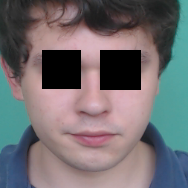

In [ ]:
cv2_imshow(rppg.rgb_roi)

In [ ]:
rppg.print_evaluation()

RGB -> RMSE: 6.2953617010755165, MAE: 4.508771929824562
LAB -> RMSE: 6.5158376553500155, MAE: 4.701754385964913
HSV -> RMSE: 6.343943098348827, MAE: 4.666666666666667
GREEN -> RMSE: 7.905139345399006, MAE: 6.5964912280701755
FUSION -> RMSE: 6.151722448535912, MAE: 4.4108187134502925


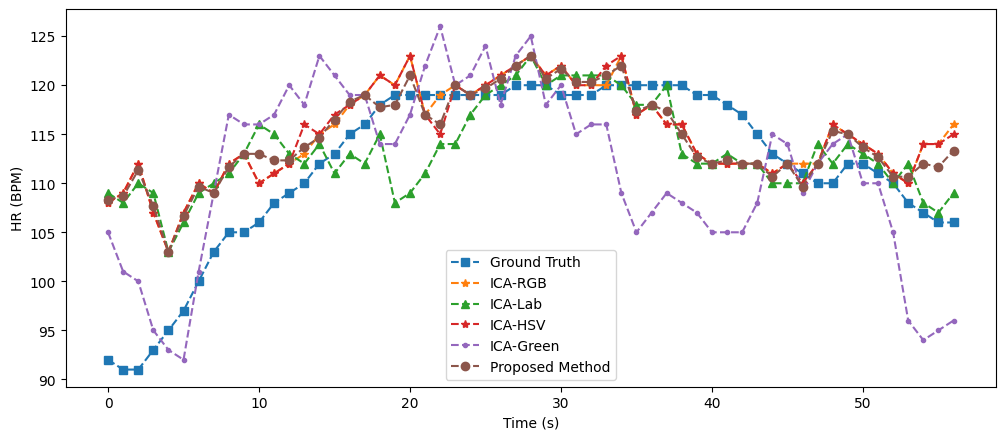

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# fusion technique
fig = figure(figsize=(12,5), dpi=100)
plt.plot(rppg.hrv_gt,'s--')
plt.plot(rppg.hrv_rgb,'*--')
plt.plot(rppg.hrv_lab,'^--')
plt.plot(rppg.hrv_hsv,'*--')
plt.plot(rppg.hrv_green,'.--')
plt.plot(rppg.hrv_fusioned,'o--')
plt.legend(['Ground Truth', 'ICA-RGB', 'ICA-Lab', 'ICA-HSV', 'ICA-Green','Proposed Method'])
plt.xlabel('Time (s)')
plt.ylabel('HR (BPM)')
fig.savefig('HRV_est.png')
plt.show()
